# PCA de importações de Santos

## Setup

### Importações

In [388]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import glob

In [389]:
dict_dtypes = pd.read_pickle("datasets/aux_carga_dtypes.pkl").to_dict()

In [390]:
df = pd.read_csv("datasets/df_rus_ua_psantos.csv", decimal=",", dtype=dict_dtypes)

### Limpeza

In [391]:
df.columns

Index(['IDCarga', 'IDAtracacao', 'Origem', 'Destino', 'CDMercadoria',
       'Tipo Operação da Carga', 'Carga Geral Acondicionamento',
       'ConteinerEstado', 'Tipo Navegação', 'FlagAutorizacao', 'FlagCabotagem',
       'FlagCabotagemMovimentacao', 'FlagConteinerTamanho', 'FlagLongoCurso',
       'FlagMCOperacaoCarga', 'FlagOffshore', 'FlagTransporteViaInterioir',
       'Percurso Transporte em vias Interiores',
       'Percurso Transporte Interiores', 'STNaturezaCarga', 'STSH2', 'STSH4',
       'Natureza da Carga', 'Sentido', 'TEU', 'QTCarga', 'VLPesoCargaBruta',
       'Ano'],
      dtype='object')

### Junção de Carga com Carga Conteinerizada

In [392]:
def criar_mestre() -> pd.DataFrame:
    global df
    df_mestre = df.copy()
    for ano in range(df["Ano"].min(), df["Ano"].max() + 1):
        print("Ano atual: ", ano)
        df_cont = pd.read_csv(f"/home/vortex/Documents/Fatec/Trabalhos/Projeto Integrador local/BD/ANTAQ/{ano}Carga_Conteinerizada.csv", sep=";", decimal=",", dtype=dict_dtypes)

        df_mestre = df_mestre.merge(df_cont,"left", "IDCarga")

        # Combinação
        df_mestre["VLPesoCargaBruta"] = df_mestre["VLPesoCargaConteinerizada"].combine_first(df_mestre["VLPesoCargaBruta"])
        df_mestre.drop("VLPesoCargaConteinerizada", axis=1, inplace=True)
        df_mestre["CDMercadoria"] = df_mestre["CDMercadoriaConteinerizada"].combine_first(df_mestre["CDMercadoria"])
        df_mestre.drop("CDMercadoriaConteinerizada", axis=1, inplace=True)
    del df_cont
    del df
    return df_mestre

In [393]:
arq = "local_df_mestre.csv"
if glob.glob(arq):
    df_mestre = pd.read_csv(arq, dtype=dict_dtypes)
    print(f"{arq} carregado!")
else:
    df_mestre = criar_mestre()
    df_mestre.to_csv(arq, index=False)
    print(f"{arq} criado!")


local_df_mestre.csv carregado!


In [394]:
df_mestre.drop(["IDAtracacao",
         "Destino",
         "Sentido",
         "Carga Geral Acondicionamento",
         "ConteinerEstado",
         "FlagConteinerTamanho"], axis=1, inplace=True)

Variáveis auxiliares

In [395]:
ano_min = df_mestre["Ano"].min()
ano_max = df_mestre["Ano"].max()

## Junção de Carga com Mercadoria

Alternativa seria pegar apenas os dois primeiros digitos de `CDMercadoria`

In [396]:
df_merc = pd.read_csv("/home/vortex/Documents/Fatec/Trabalhos/Projeto Integrador local/BD/ANTAQ/Mercadoria.csv", sep=";")

In [397]:
df_mestre = df_mestre.merge(df_merc.loc[:, ["CDMercadoria", "CDNCMSH2"]], on="CDMercadoria")

In [398]:
df_mestre.drop("CDMercadoria", axis=1, inplace=True)

### Categorização

In [399]:
df_cat = df_mestre.copy()

In [400]:
for col in df_cat:
    if df_cat[col].dtype == "category":
        df_cat[col] = df_cat[col].cat.codes
    if df_cat[col].dtype == "object":
        df_cat[col] = df_cat[col].astype("category").cat.codes

In [401]:
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10786 entries, 0 to 10785
Data columns (total 22 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   IDCarga                                 10786 non-null  int64  
 1   Origem                                  10786 non-null  int8   
 2   Tipo Operação da Carga                  10786 non-null  int8   
 3   Tipo Navegação                          10786 non-null  int8   
 4   FlagAutorizacao                         10786 non-null  int8   
 5   FlagCabotagem                           10786 non-null  boolean
 6   FlagCabotagemMovimentacao               10786 non-null  boolean
 7   FlagLongoCurso                          10786 non-null  boolean
 8   FlagMCOperacaoCarga                     10786 non-null  boolean
 9   FlagOffshore                            10786 non-null  boolean
 10  FlagTransporteViaInterioir              10786 non-null  bo

In [402]:
df_cat.drop("IDCarga",axis=1, inplace=True)

In [403]:
df_cat = df_cat.fillna(0)

### Normalização dos dados

In [404]:
normalizador = StandardScaler()

In [405]:
arr_cat_norm = normalizador.fit_transform(df_cat)

## Exploração de df_mestre

### Tamanho da amostra

In [406]:
df_mestre.shape

(10786, 22)

10782 entradas distribuídas ao longo de 22 variáveis

In [407]:
df_mestre["Origem"].str.contains("UA...").value_counts()

Origem
False    10324
True       462
Name: count, dtype: int64

10324 entradas russas e 462 entradas ucranianas

In [408]:
f"{10324 * 100/ 10786:.2f}% de entradas russas"

'95.72% de entradas russas'

In [409]:
f"{462 * 100/ 10786:.2f}% de entradas ucranianas"

'4.28% de entradas ucranianas'

In [410]:
df_mestre["Natureza da Carga"].cat.categories

Index(['Carga Conteinerizada', 'Carga Geral', 'Granel Líquido e Gasoso',
       'Granel Sólido'],
      dtype='object')

Ano de 2018 e 2023

In [436]:
df_mestre[df_mestre["Ano"] == 2018].shape

(1228, 22)

In [439]:
df_mestre[df_mestre["Ano"] == 2023].shape

(2164, 22)

## PCA

### Estimador e projeção

In [411]:
pca = PCA()

In [412]:
df_proj = pca.fit_transform(arr_cat_norm)

In [413]:
df_proj = pd.DataFrame(df_proj, columns=pca.get_feature_names_out())

### Dataframe da matriz de covariânica

In [414]:
df_cov_m = pd.DataFrame(pca.get_covariance(), df_cat.columns, df_cat.columns)
df_cov_m[["STSH2", "STSH4"]].loc[["STSH2", "STSH4"]]

,STSH2,STSH4
STSH2,1.000093,0.675441
STSH4,0.675441,1.000093


Covariância entre colunas do PCA0

In [415]:
df_cov_m[["STSH2", "STNaturezaCarga", "STSH4"]].loc[["STSH2", "STNaturezaCarga", "STSH4"]]

,STSH2,STNaturezaCarga,STSH4
STSH2,1.000093,0.836816,0.675441
STNaturezaCarga,0.836816,1.000093,0.550732
STSH4,0.675441,0.550732,1.000093


In [416]:
df_cov_m[["Natureza da Carga", "Ano", "STSH4"]].loc[["Natureza da Carga", "Ano", "STSH4"]]

,Natureza da Carga,Ano,STSH4
Natureza da Carga,1.000093,0.473830,-0.099589
Ano,0.473830,1.000093,-0.011886
STSH4,-0.099589,-0.011886,1.000093


Autovalores

In [417]:
pca.explained_variance_[:2]

array([2.47323518, 2.04864162])

Autovetores

In [418]:
for arr in pca.components_[:2]:
    el_txt = f"({arr[0]:.2}"
    print(el_txt, end="")
    for el in arr[1:]:
        el_txt = f"{el:.2}"
        print(", " + el_txt,end="")
    print(")\n")

(0.068, -0.029, -5.6e-17, 1.1e-16, 0.0, 0.0, 0.0, 0.0, 0.0, -3.4e-21, 2.1e-22, 0.0, -0.53, -0.58, -0.43, -0.26, 0.16, 0.071, -0.15, -0.19, 0.18)

(-0.24, 0.099, 0.0, 2.8e-17, -5.6e-17, 0.0, 0.0, -4.3e-19, 0.0, -6.8e-21, 8.5e-22, 0.0, -0.24, -0.19, -0.35, 0.52, -0.31, -0.057, 0.33, 0.38, -0.3)



### Influência nas colunas do PCA

In [419]:
df_comp = pd.DataFrame(pca.components_, pca.get_feature_names_out(), df_cat.columns)

Maior influência em pca0

In [420]:
df_comp.loc[:"pca0",df_comp.loc["pca0"].abs().sort_values(ascending=False).index]

,STSH2,STNaturezaCarga,STSH4,Natureza da Carga,Ano,CDNCMSH2,TEU,VLPesoCargaBruta,QTCarga,Origem,...,FlagAutorizacao,Tipo Navegação,FlagTransporteViaInterioir,Percurso Transporte em vias Interiores,Percurso Transporte Interiores,FlagOffshore,FlagMCOperacaoCarga,FlagLongoCurso,FlagCabotagemMovimentacao,FlagCabotagem
pca0,-0.579066,-0.529075,-0.431628,-0.263513,-0.189214,0.182867,0.161138,-0.153017,0.070529,0.06788,...,1.110223e-16,-5.551115e-17,-3.388132e-21,2.117582e-22,0.0,0.0,0.0,0.0,0.0,0.0


Maior influência em pca1

In [421]:
df_comp.loc["pca1":"pca1",df_comp.loc["pca1"].abs().sort_values(ascending=False).index]

,Natureza da Carga,Ano,STSH4,VLPesoCargaBruta,TEU,CDNCMSH2,STNaturezaCarga,Origem,STSH2,Tipo Operação da Carga,...,FlagCabotagem,FlagAutorizacao,FlagMCOperacaoCarga,FlagTransporteViaInterioir,Percurso Transporte em vias Interiores,FlagOffshore,Percurso Transporte Interiores,FlagLongoCurso,FlagCabotagemMovimentacao,Tipo Navegação
pca1,0.521641,0.380599,-0.349839,0.333286,-0.30848,-0.303214,-0.236306,-0.23624,-0.194266,0.099133,...,-5.551115e-17,2.775558e-17,-4.336809e-19,-6.776264e-21,8.470329e-22,0.0,0.0,0.0,0.0,0.0


In [441]:
df_mestre["STSH2"]

0        Exclusivo
1        Exclusivo
2        Exclusivo
3        Exclusivo
4        Exclusivo
           ...    
10781    Exclusivo
10782    Exclusivo
10783    Exclusivo
10784    Exclusivo
10785    Exclusivo
Name: STSH2, Length: 10786, dtype: category
Categories (2, object): ['Compartilhado', 'Exclusivo']

# Plotagem

## Colorido por Natureza da Carga

In [423]:
x_col = "Natureza da Carga"

In [424]:
df_mestre[x_col].unique().tolist()

['Granel Sólido',
 'Carga Conteinerizada',
 'Carga Geral',
 'Granel Líquido e Gasoso']

In [434]:
natu_estilos = {
    "Granel Sólido": ('#1f77b4', 'o'),
    "Carga Conteinerizada": ('#ff7f0e', 's'),
    "Carga Geral": ('#2ca02c', 'v'),
    "Granel Líquido e Gasoso": ('#d62728', '^')
}

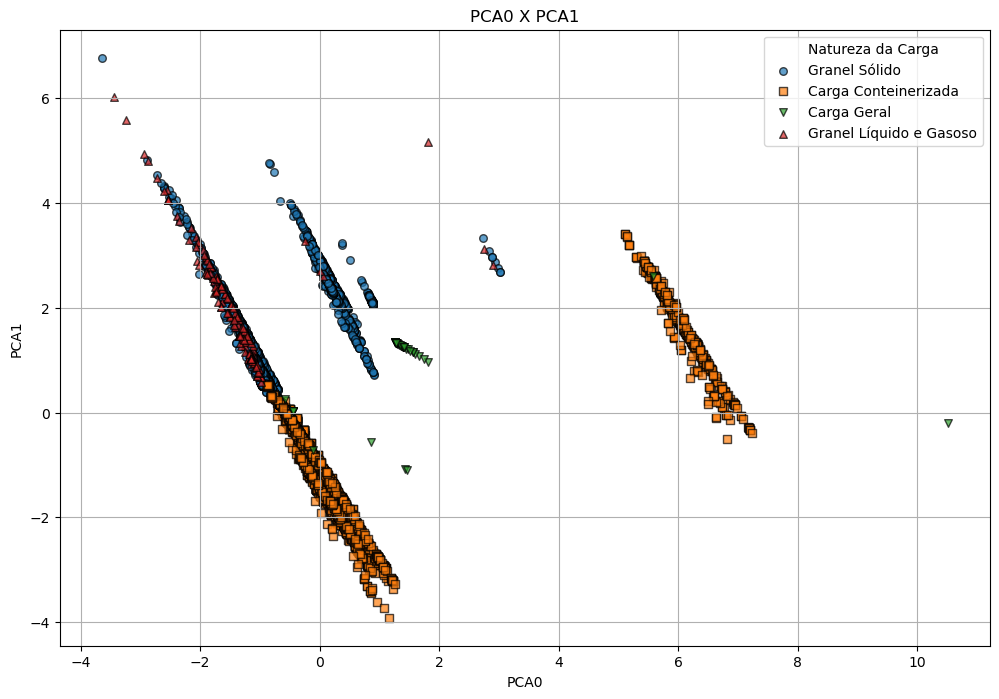

In [ ]:
# Total
def plot_total_natu():
    plt.figure(figsize=(12, 8))
    plt.title("PCA0 X PCA1")
    plt.xlabel("PCA0")
    plt.ylabel("PCA1")
    plt.grid(True)

    # Plotar os dados
    for x_, (cor, marker) in natu_estilos.items():
        subset = df_proj[df_mestre[x_col] == x_]
        plt.scatter(subset['pca0'], subset['pca1'], marker=marker, color=cor, label=str(x_), alpha=0.7, edgecolor='k', s=30)

    plt.legend(title=f"Natureza da Carga")
    plt.show()

plot_total_natu()

## Colorido por ano

### Geral

Sem padrão discernível

In [427]:
x_col = "Ano"

In [428]:
df_mestre[x_col].unique().tolist()

[2018, 2019, 2020, 2021, 2022, 2023]

In [429]:
x_estilos = {
    2018: ('#1f77b4', 'o'),
    2019: ('#ff7f0e', 's'),
    2020: ('#2ca02c', 'v'),
    2021: ('#d62728', '^'),
    2022: ('#9467bd', 'D'),
    2023: ('#8c564b', 'P')
}

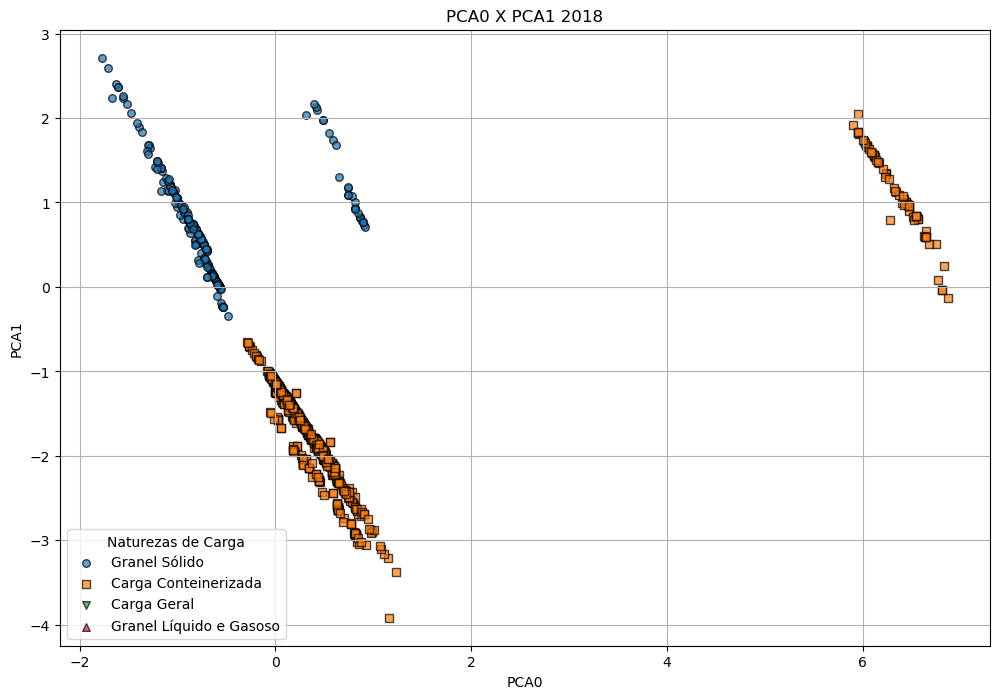

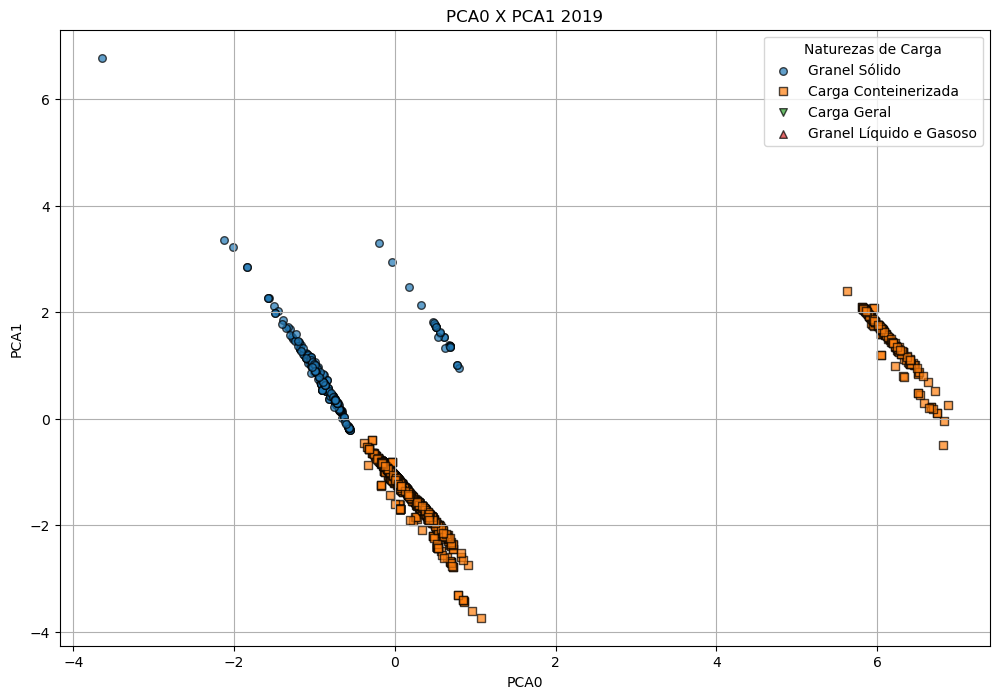

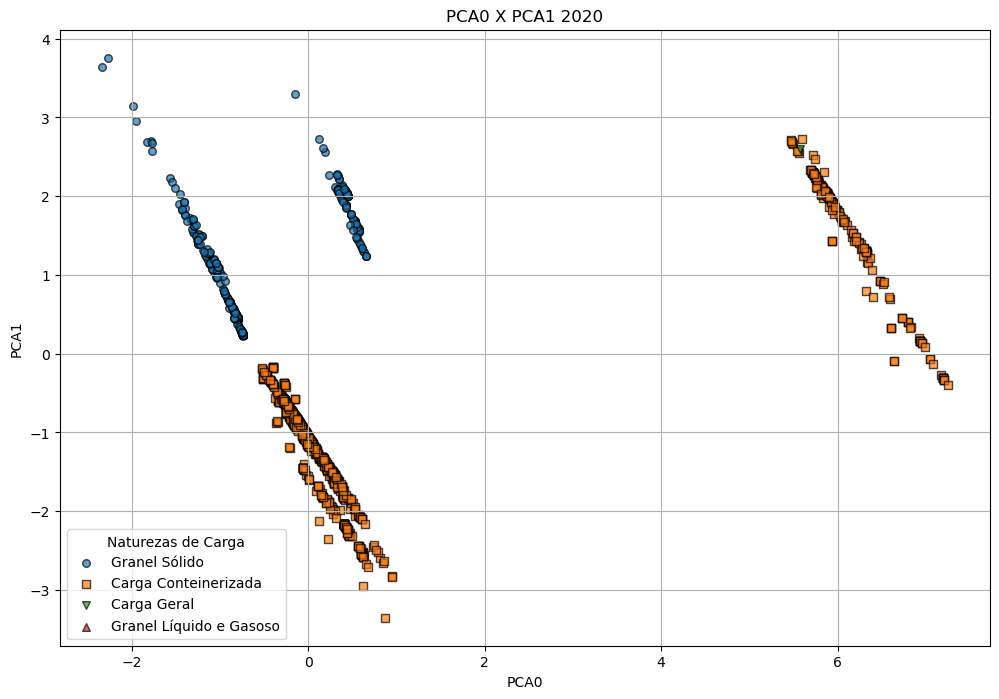

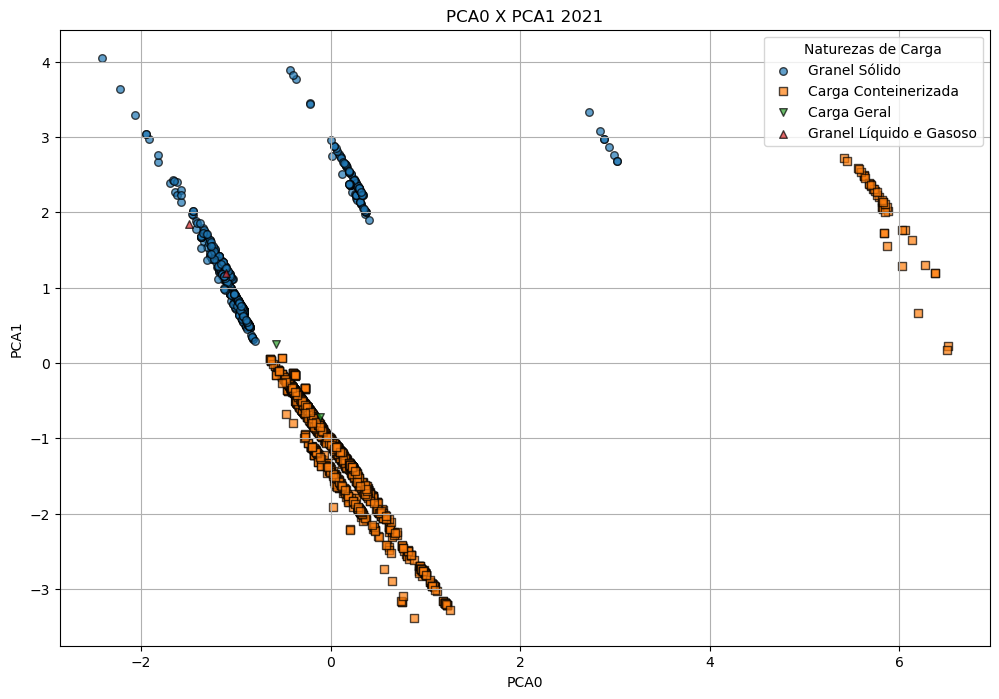

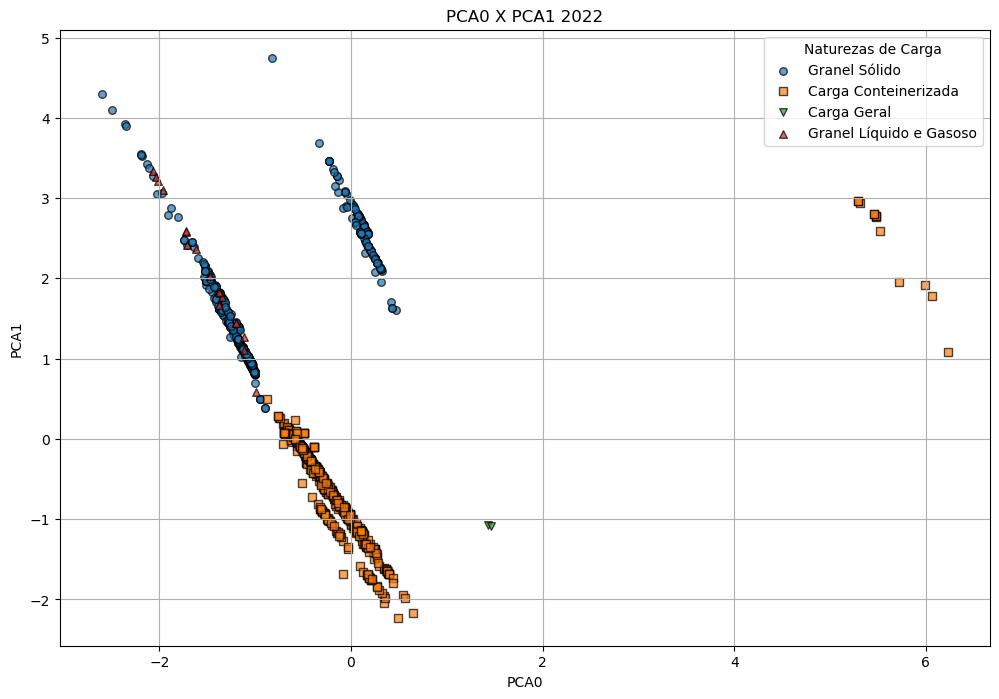

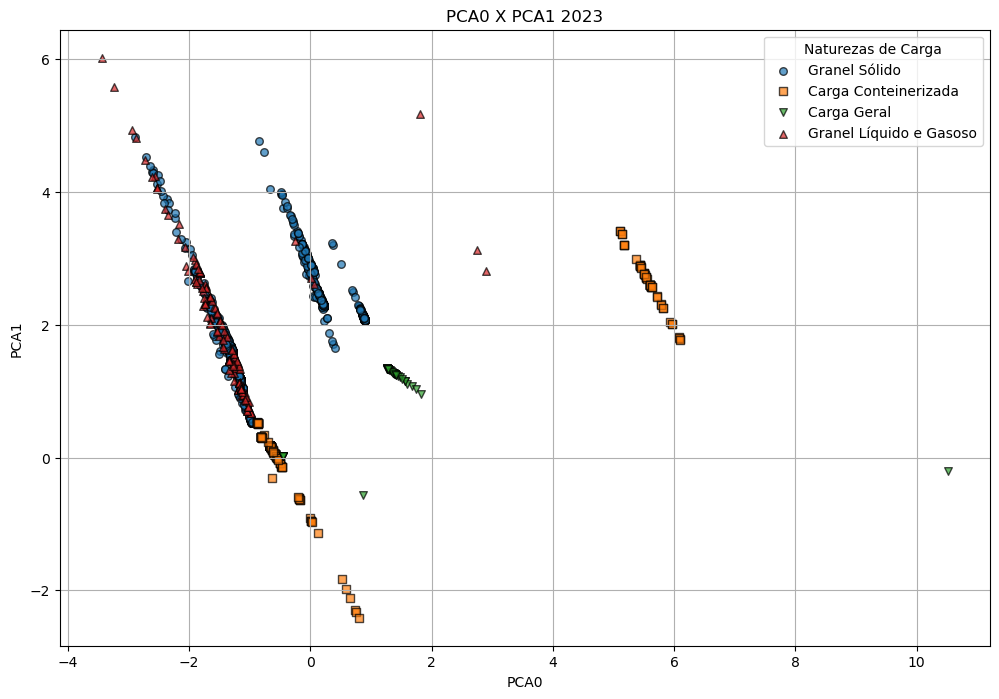

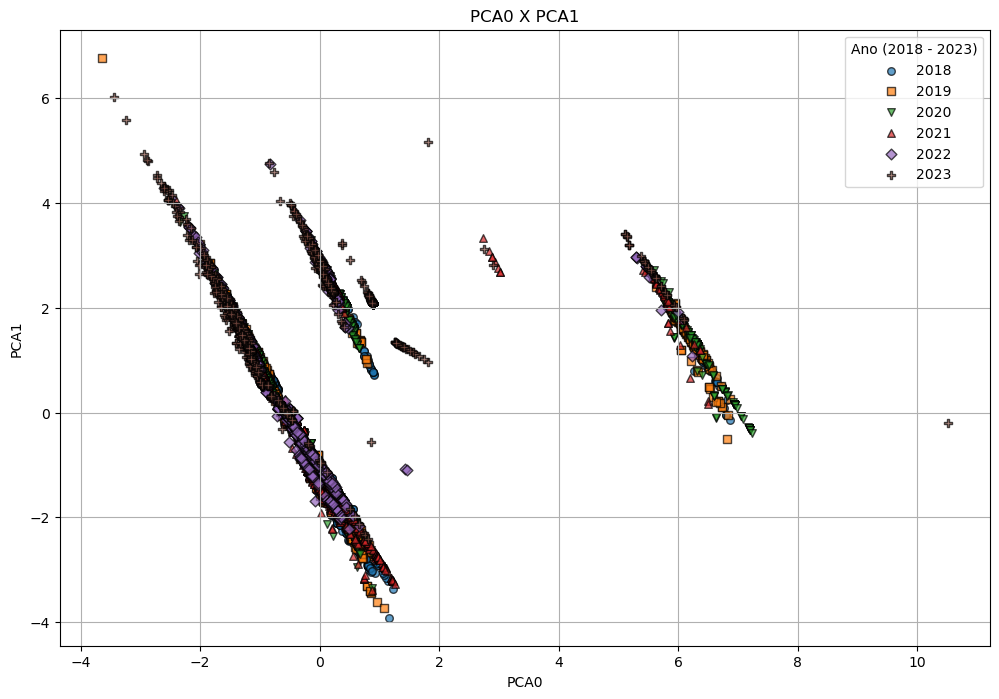

In [435]:
# Anual
def plot_anual():
    for ano in range(2018, 2023 + 1):
        plt.figure(figsize=(12, 8))
        plt.title(f"PCA0 X PCA1 {ano}")
        plt.xlabel("PCA0")
        plt.ylabel("PCA1")
        plt.grid(True)

        # Plotar os dados
        for x_, (cor, marker) in natu_estilos.items():
            subset = df_proj[(df_mestre["Natureza da Carga"] == x_) & (df_mestre[x_col] == ano)]
            plt.scatter(subset['pca0'], subset['pca1'], marker=marker, color=cor, label=str(x_), alpha=0.7, edgecolor='k', s=30)
        
        plt.legend(title=f"Naturezas de Carga")
        plt.show()


# Total
def plot_total():
    plt.figure(figsize=(12, 8))
    plt.title("PCA0 X PCA1")
    plt.xlabel("PCA0")
    plt.ylabel("PCA1")
    plt.grid(True)

    # Plotar os dados
    for x_, (cor, marker) in x_estilos.items():
        subset = df_proj[df_mestre[x_col] == x_]
        plt.scatter(subset['pca0'], subset['pca1'], marker=marker, color=cor, label=str(x_), alpha=0.7, edgecolor='k', s=30)

    plt.legend(title=f"Ano (2018 - 2023)")
    plt.show()

plot_anual()
plot_total()

Sem padrão...

## Colorido por país

In [286]:
x_col = "Origem"

In [287]:
df_mestre[x_col].unique().tolist()

['RU006',
 'RULED',
 'RUNVS',
 'UAILK',
 'UAODS',
 'RUTUA',
 'UAYUZ',
 'RUKRR',
 'RUZZZ',
 'RUMMK',
 'RUKGD',
 'RUPRI',
 'RUVVO',
 'RUKAV']

In [288]:
x_estilos = {
    'RU': ('#1f77b4', 'o'),
    'UA': ('#ff7f0e', 's')
}

Setup para 3D

In [289]:
# %matplotlib widget
%matplotlib inline

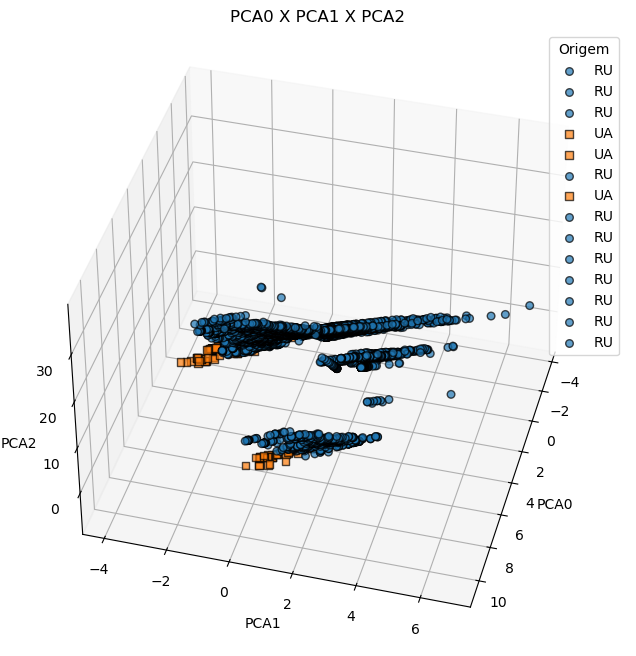

In [290]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection='3d')
plt.title("PCA0 X PCA1 X PCA2")
plt.xlabel("PCA0")
plt.ylabel("PCA1")
ax.set_zlabel("PCA2")
plt.grid(True)

# Plotar os dados
for porto in df_mestre[x_col].unique().tolist():
    x_ = porto[:2]
    (cor, marker) = x_estilos[x_]
    subset = df_proj[df_mestre[x_col] == porto]
    ax.scatter(subset['pca0'], subset['pca1'], subset['pca2'], marker=marker, color=cor, label=str(x_), alpha=0.7, edgecolor='k', s=30)

plt.legend(title="Origem")
ax.view_init(azim=15, elev=40)
plt.show()

Nada demais!

### Colorido por Natureza de Carga

In [291]:
x_col = "Natureza da Carga"

In [292]:
df_mestre[x_col].unique().tolist()

['Granel Sólido',
 'Carga Conteinerizada',
 'Carga Geral',
 'Granel Líquido e Gasoso']

In [293]:
x_estilos = {
    'Granel Sólido': ('#1f77b4', 'o'),
    'Carga Conteinerizada': ('#ff7f0e', 's'),
    'Carga Geral': ('#2ca02c', 'v'),
    'Granel Líquido e Gasoso': ('#d62728', '^')
}

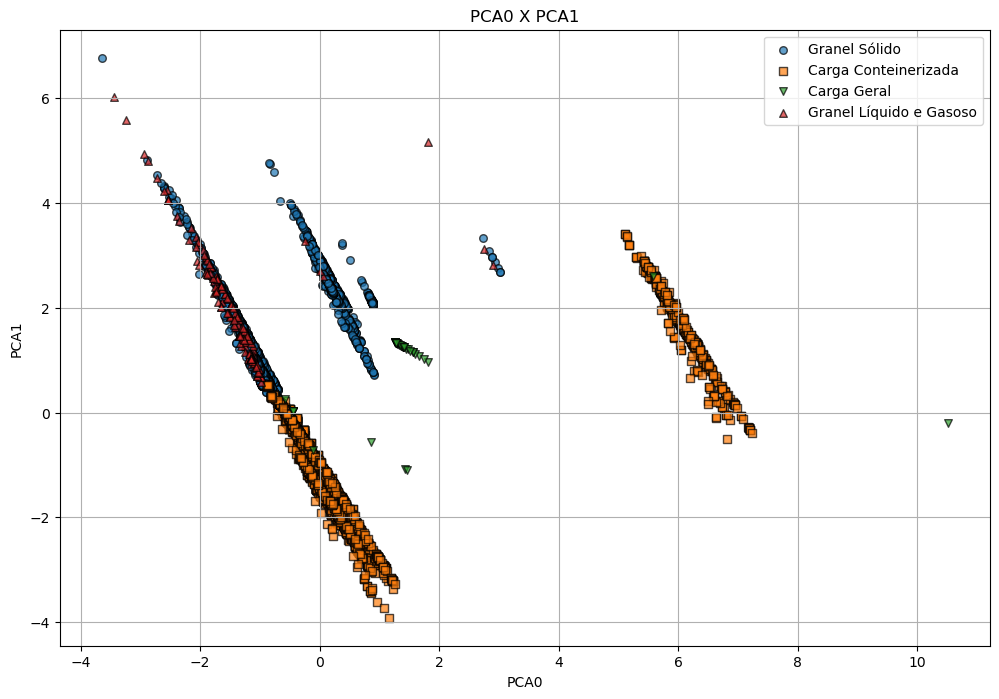

In [294]:
plt.figure(figsize=(12, 8))
plt.title("PCA0 X PCA1")
plt.xlabel("PCA0")
plt.ylabel("PCA1")
plt.grid(True)

# Plotar os dados
for x_, (cor, marker) in x_estilos.items():
    subset = df_proj[df_mestre[x_col] == x_]
    plt.scatter(subset['pca0'], subset['pca1'], marker=marker, color=cor, label=str(x_), alpha=0.7, edgecolor='k', s=30)

plt.legend()
plt.show()

Relação com ano e tipo de carga?

## Gradiente por capítulo de mercadoria

Normaliza-se os códigos do CDMercadoria

In [295]:
norm_codes = plt.Normalize(df_cat['CDNCMSH2'].min(), df_cat['CDNCMSH2'].max())

In [296]:
len(df_mestre['CDNCMSH2'].unique().tolist())

65

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


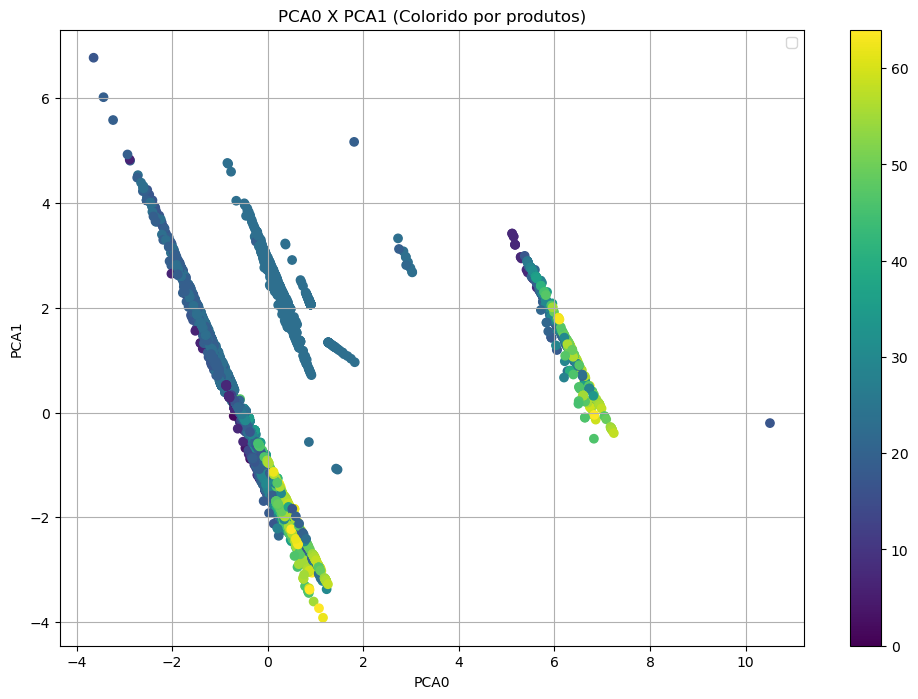

In [297]:
plt.figure(figsize=(12, 8))
plt.title("PCA0 X PCA1 (Colorido por produtos)")
plt.xlabel("PCA0")
plt.ylabel("PCA1")
plt.grid(True)

scatter = plt.scatter(
    df_proj['pca0'], df_proj['pca1'],
    c=df_cat['CDNCMSH2'], cmap='viridis', norm=norm_codes
)

cbar = plt.colorbar(scatter)
cd_mercs = df_mestre['CDNCMSH2'].unique().tolist()
# cbar.set_ticks(range(0, len(cd_mercs), 5))
# cbar.set_ticklabels(cd_mercs[0::5])

plt.legend()
plt.show()

Sem padrão claro

## Gradiente por Origem

In [298]:
norm_codes = plt.Normalize(df_cat['Origem'].min(), df_cat['Origem'].max())

In [299]:
cat_origem = df_mestre["Origem"].astype("category").cat.categories

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


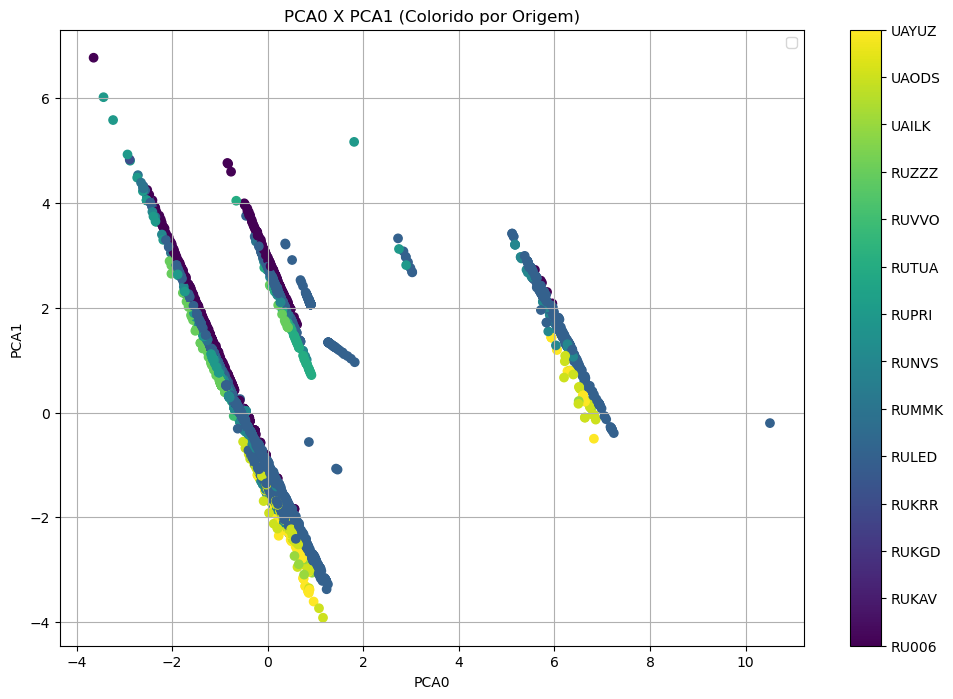

In [300]:
plt.figure(figsize=(12, 8))
plt.title("PCA0 X PCA1 (Colorido por Origem)")
plt.xlabel("PCA0")
plt.ylabel("PCA1")
plt.grid(True)

scatter = plt.scatter(
    df_proj['pca0'], df_proj['pca1'],
    c=df_cat['Origem'], cmap='viridis', norm=norm_codes
)

cbar = plt.colorbar(scatter)
cbar.set_ticks(range(len(cat_origem)))
cbar.set_ticklabels(cat_origem)

plt.legend()
plt.show()

## Por STs

### Colorido por STSH2

In [301]:
x_col = "STSH2"

In [302]:
df_mestre[x_col].unique().tolist()

['Exclusivo', 'Compartilhado']

In [303]:
x_estilos = {
    'Exclusivo': ('#1f77b4', 'o'),
    'Compartilhado': ('#ff7f0e', 's')
}

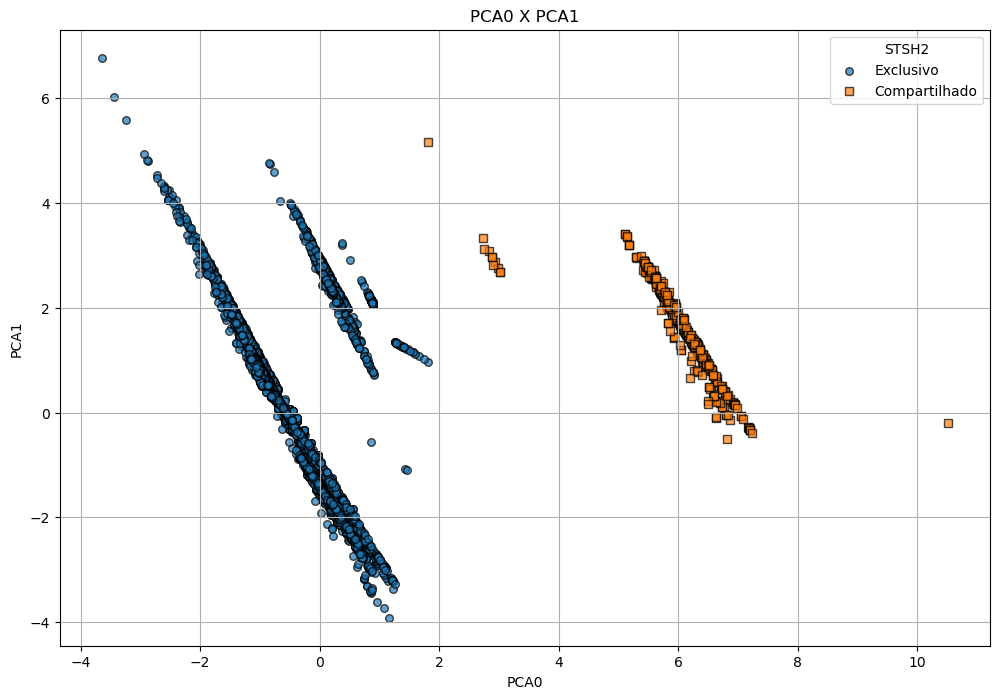

In [304]:
plt.figure(figsize=(12, 8))
plt.title("PCA0 X PCA1")
plt.xlabel("PCA0")
plt.ylabel("PCA1")
plt.grid(True)

# Plotar os dados
for x_, (cor, marker) in x_estilos.items():
    subset = df_proj[df_mestre[x_col] == x_]
    plt.scatter(subset['pca0'], subset['pca1'], marker=marker, color=cor, label=str(x_), alpha=0.7, edgecolor='k', s=30)

plt.legend(title="STSH2")
plt.show()

In [305]:
df_mestre["STSH2"].cat.categories

Index(['Compartilhado', 'Exclusivo'], dtype='object')

Compartilhado = 0

Exclusivo = 1

In [306]:
df_mestre["STSH2"].cat.codes.unique()

array([1, 0], dtype=int8)

In [307]:
df_mestre["STSH2"].head(1)

0    Exclusivo
Name: STSH2, dtype: category
Categories (2, object): ['Compartilhado', 'Exclusivo']

### Colorido por STNaturezaCarga

In [308]:
x_col = "STNaturezaCarga"

In [309]:
df_mestre[x_col].unique().tolist()

['Exclusivo', 'Compartilhado']

In [310]:
x_estilos = {
    'Exclusivo': ('#1f77b4', 'o'),
    'Compartilhado': ('#ff7f0e', 's')
}

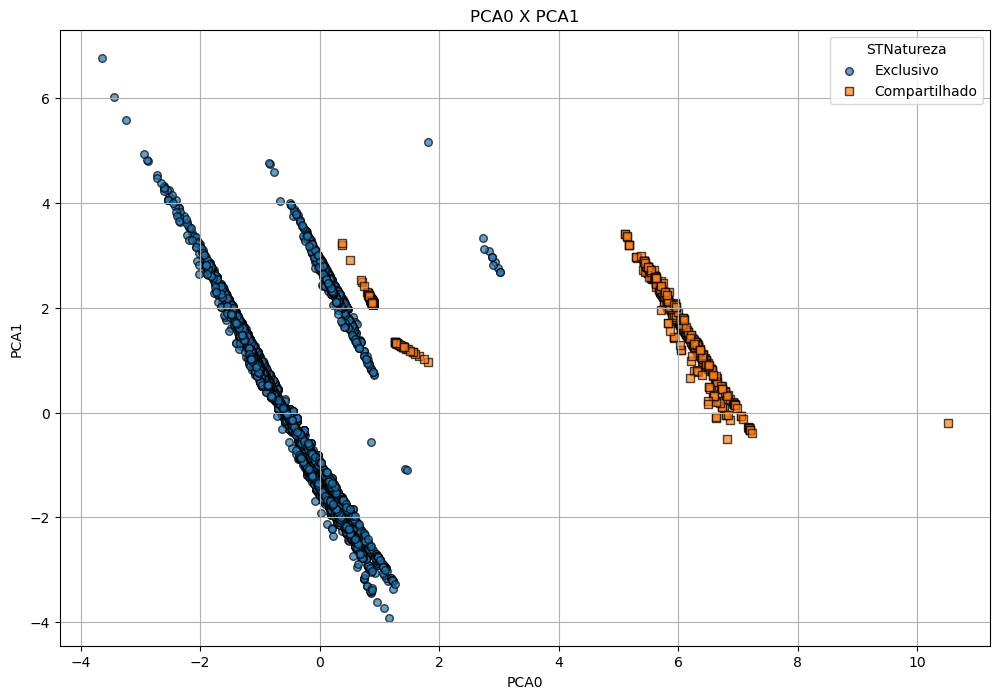

In [311]:
plt.figure(figsize=(12, 8))
plt.title("PCA0 X PCA1")
plt.xlabel("PCA0")
plt.ylabel("PCA1")
plt.grid(True)

# Plotar os dados
for x_, (cor, marker) in x_estilos.items():
    subset = df_proj[df_mestre[x_col] == x_]
    plt.scatter(subset['pca0'], subset['pca1'], marker=marker, color=cor, label=str(x_), alpha=0.7, edgecolor='k', s=30)

plt.legend(title="STNatureza")
plt.show()

### Colorido por STSH4

In [312]:
x_col = "STSH4"

In [313]:
df_mestre[x_col].unique().tolist()

['Exclusivo', 'Compartilhado']

In [314]:
x_estilos = {
    'Exclusivo': ('#1f77b4', 'o'),
    'Compartilhado': ('#ff7f0e', 's')
}

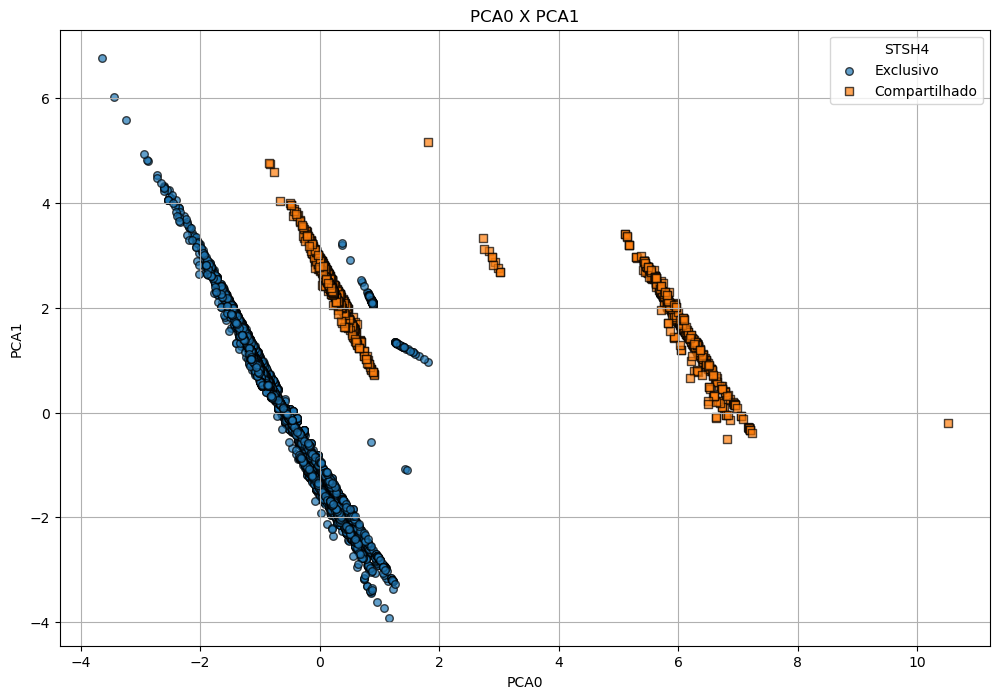

In [315]:
plt.figure(figsize=(12, 8))
plt.title("PCA0 X PCA1")
plt.xlabel("PCA0")
plt.ylabel("PCA1")
plt.grid(True)

# Plotar os dados
for x_, (cor, marker) in x_estilos.items():
    subset = df_proj[df_mestre[x_col] == x_]
    plt.scatter(subset['pca0'], subset['pca1'], marker=marker, color=cor, label=str(x_), alpha=0.7, edgecolor='k', s=30)

plt.legend(title="STSH4")
plt.show()

### Colorido por STSH4 e STSH2

In [316]:
from sklearn.linear_model import LinearRegression

In [317]:
x_estilos = {
    'Exclusivo Exclusivo': ('#1f77b4', 'o'),
    'Exclusivo Compartilhado': ('#ff7f0e', 's'),
    'Compartilhado Compartilhado': ('#d62728', '^')
}

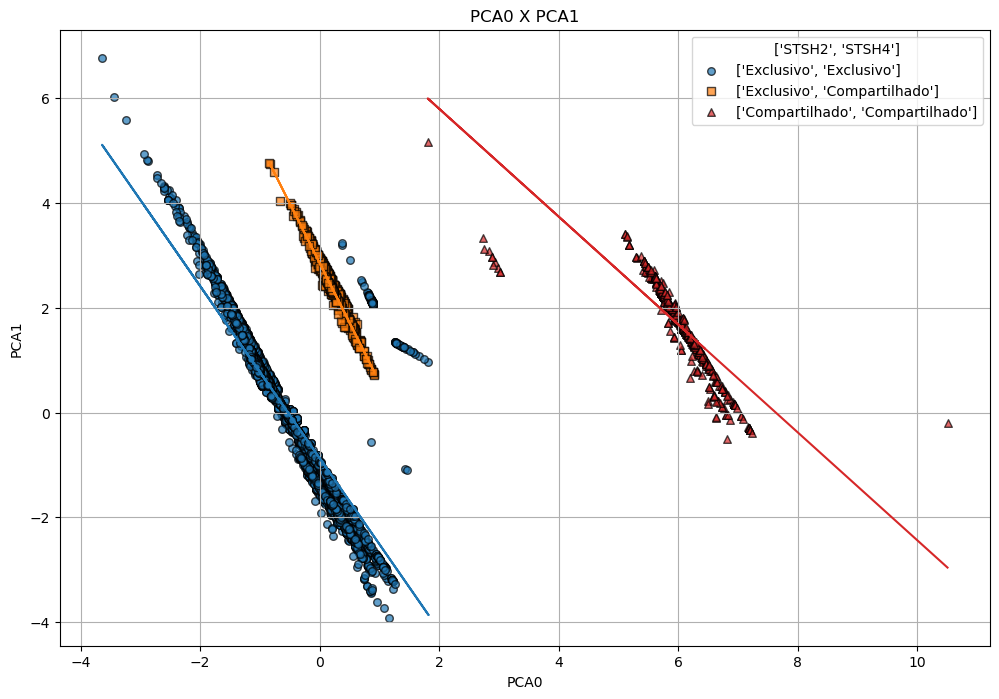

In [318]:
plt.figure(figsize=(12, 8))
plt.title("PCA0 X PCA1")
plt.xlabel("PCA0")
plt.ylabel("PCA1")
plt.grid(True)

# Plotar os dados
for x_, (cor, marker) in x_estilos.items():
    # Scatter plot
    x_ = x_.split(" ")
    subset = df_proj[(df_mestre["STSH2"] == x_[0]) & (df_mestre["STSH4"] == x_[1])]
    plt.scatter(subset['pca0'], subset['pca1'], marker=marker, color=cor, label=str(x_), alpha=0.7, edgecolor='k', s=30)
    
    # Linha de Regressão linear
    model = LinearRegression()
    model.fit(np.array(subset['pca0']).reshape(-1, 1), np.array(subset['pca1']))
    y_pred = model.predict(np.array(subset['pca0']).reshape(-1, 1))
    plt.plot(subset['pca0'], y_pred, color=cor)

plt.legend(title="['STSH2', 'STSH4']")
plt.show()

Realmente, é impossível o STSH2 ser compartilhado e o STSH4 ser exclusivo!

## Gradiente por Peso de Carga Bruta

In [319]:
norm_codes = plt.Normalize(df_cat['VLPesoCargaBruta'].min(), df_cat['VLPesoCargaBruta'].max())

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


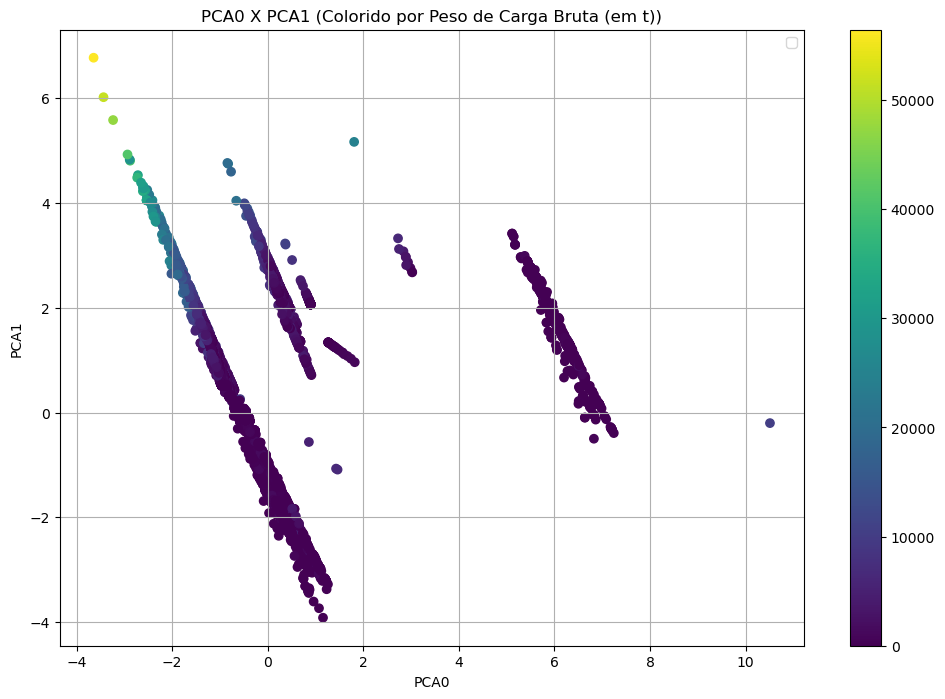

In [320]:
plt.figure(figsize=(12, 8))
plt.title("PCA0 X PCA1 (Colorido por Peso de Carga Bruta (em t))")
plt.xlabel("PCA0")
plt.ylabel("PCA1")
plt.grid(True)

scatter = plt.scatter(
    df_proj['pca0'], df_proj['pca1'],
    c=df_cat['VLPesoCargaBruta'], cmap='viridis', norm=norm_codes
)

cbar = plt.colorbar(scatter)

plt.legend()
plt.show()

## Produtos mais típicos

### Mais típico por `pca0` e `pca1`

Produtos com menor variância (por pca0 e pca1)

In [321]:
ds = np.linalg.norm(df_proj.loc[:,["pca0", "pca1"]], axis=1)

indice_tipico = np.argmin(ds)
elemento_tipico = df_mestre.iloc[indice_tipico]

In [322]:
elemento_tipico

IDCarga                                                 31006306
Origem                                                     RU006
Tipo Operação da Carga                    Longo Curso Importação
Tipo Navegação                                       Longo Curso
FlagAutorizacao                                                S
FlagCabotagem                                              False
FlagCabotagemMovimentacao                                  False
FlagLongoCurso                                              True
FlagMCOperacaoCarga                                         True
FlagOffshore                                               False
FlagTransporteViaInterioir                                 False
Percurso Transporte em vias Interiores                       NaN
Percurso Transporte Interiores                               NaN
STNaturezaCarga                                        Exclusivo
STSH2                                                  Exclusivo
STSH4                    

### Produto mais típico em geral

Produtos com menor variância (por todas colunas)

In [323]:
ds = np.linalg.norm(df_proj, axis=1)

indice_tipico = np.argmin(ds)
elemento_tipico = df_mestre.iloc[indice_tipico]

In [324]:
elemento_tipico

IDCarga                                                 27813613
Origem                                                     RULED
Tipo Operação da Carga                    Longo Curso Importação
Tipo Navegação                                       Longo Curso
FlagAutorizacao                                                S
FlagCabotagem                                              False
FlagCabotagemMovimentacao                                  False
FlagLongoCurso                                              True
FlagMCOperacaoCarga                                         True
FlagOffshore                                               False
FlagTransporteViaInterioir                                 False
Percurso Transporte em vias Interiores                       NaN
Percurso Transporte Interiores                               NaN
STNaturezaCarga                                        Exclusivo
STSH2                                                  Exclusivo
STSH4                    

### Produtos mais típicos ano a ano

In [325]:
elemento_tipico_anox = []
indexes_tipicos = []
for ano in range(ano_min, ano_max + 1):# plt.scatter(df_proj['pca0'], df_proj['pca1'], color=cor, alpha=0.7, edgecolor='k', s=30)

    df_mestre_anual = df_mestre[df_mestre["Ano"] == ano]
    ds = np.linalg.norm(df_proj[df_mestre["Ano"] == ano], axis=1)

    indice_tipico = np.argmin(ds)
    elemento_tipico_anox.append(df_mestre_anual.iloc[indice_tipico])
    indexes_tipicos.append(df_mestre_anual.index[indice_tipico])

In [443]:
x_estilos = {
    2018: ('#1f77b4', 'o'),
    2019: ('#ff7f0e', 's'),
    2020: ('#2ca02c', 'v'),
    2021: ('#d62728', '^'),
    2022: ('#9467bd', 'D'),
    2023: ('#8c564b', 'P')
}

In [327]:
df_mestre.loc[indexes_tipicos]

,IDCarga,Origem,Tipo Operação da Carga,Tipo Navegação,FlagAutorizacao,FlagCabotagem,FlagCabotagemMovimentacao,FlagLongoCurso,FlagMCOperacaoCarga,FlagOffshore,...,Percurso Transporte Interiores,STNaturezaCarga,STSH2,STSH4,Natureza da Carga,TEU,QTCarga,VLPesoCargaBruta,Ano,CDNCMSH2
124,21109674,RULED,Longo Curso Importação,Longo Curso,S,False,False,True,True,False,...,NaN,Exclusivo,Exclusivo,Exclusivo,Carga Conteinerizada,22.0,11,45.33,2018,34
1630,24003424,RULED,Longo Curso Importação,Longo Curso,S,False,False,True,True,False,...,NaN,Exclusivo,Exclusivo,Exclusivo,Carga Conteinerizada,24.0,12,6.32,2019,34
3998,27052976,RULED,Longo Curso Importação,Longo Curso,S,False,False,True,True,False,...,NaN,Exclusivo,Exclusivo,Exclusivo,Carga Conteinerizada,20.0,10,3.73,2020,34
4795,27813613,RULED,Longo Curso Importação,Longo Curso,S,False,False,True,True,False,...,NaN,Exclusivo,Exclusivo,Exclusivo,Carga Conteinerizada,30.0,30,38.19,2021,34
7613,30831683,RULED,Longo Curso Importação,Longo Curso,S,False,False,True,True,False,...,NaN,Exclusivo,Exclusivo,Exclusivo,Carga Conteinerizada,32.0,16,463.77,2022,31
9048,33880788,RULED,Longo Curso Importação,Longo Curso,S,False,False,True,True,False,...,NaN,Exclusivo,Exclusivo,Exclusivo,Carga Conteinerizada,10.0,5,18.12,2023,38


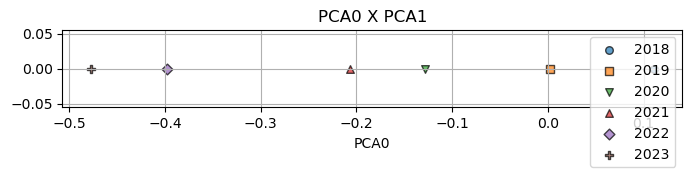

In [446]:
plt.figure(figsize=(8, 1))
plt.title("PCA0 X PCA1")
plt.xlabel("PCA0")
plt.grid(True)

# Plotar os dados
cor = []
marker = []
for ano, (cor, marker) in x_estilos.items():
    index_ano = df_mestre.loc[indexes_tipicos]
    index_ano = index_ano.index[index_ano["Ano"] == ano]
    plt.scatter(df_proj['pca0'].loc[index_ano], np.zeros_like(df_proj['pca0'].loc[index_ano]), marker=marker, color=cor, label=str(ano), alpha=0.7, edgecolor='k', s=30)

plt.legend()
plt.show()

Ano com menor variância é 2019

Com o passar dos anos houve uma mudança na natureza/tipo da carga típica movimenta